In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn import tree

from IPython.display import SVG, display
from graphviz import Source

from IPython.display import HTML
style = '<style>svg{width:30% !important;height:10% !important;)</style>'
HTML(style)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.svm import SVC

In [2]:
wine = pd.read_csv('winequality-red.csv',sep=';')
wine = wine.rename(columns={'fixed acidity': 'fixed_acidity',
                            'volatile acidity': 'volatile_acidity',
                            'citric acid': 'citric_acid',
                            'residual sugar': 'residual_sugar',
                            'free sulfur dioxide': 'free_sulfur_dioxide',
                            'total sulfur dioxide': 'total_sulfur_dioxide'
                            }) 

# Анализ данных

In [3]:
wine.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile_acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric_acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual_sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free_sulfur_dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total_sulfur_dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


Датасет состоит из 12 колонок: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality.

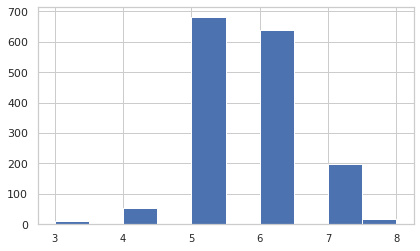

In [4]:
wine.quality.hist(xlabelsize=10)

Чаще всего встречаются оценки 5 и 6.                                                                                        
Оценки 3, 4, 8 встречаются очень редко.

In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed_acidity           1599 non-null float64
volatile_acidity        1599 non-null float64
citric_acid             1599 non-null float64
residual_sugar          1599 non-null float64
chlorides               1599 non-null float64
free_sulfur_dioxide     1599 non-null float64
total_sulfur_dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


В данных нету пропущенных значений.

In [3]:
# Сгенерируем еще одну фичу 
# без нее алгоритмы показывали плохой результат 
# quality 3-4 -> 1
# quality 5-6 -> 2
# quality 7-8 -> 3

rating = []
for score in wine['quality']:
    if score in [3, 4]:
        rating.append(1)
    elif score in [5, 6]:
        rating.append(2)
    else:
        rating.append(3)
wine['rating'] = rating      

In [7]:
# Теперь у нас есть новая колонка
print(*wine.columns, sep='\n')

fixed_acidity
volatile_acidity
citric_acid
residual_sugar
chlorides
free_sulfur_dioxide
total_sulfur_dioxide
density
pH
sulphates
alcohol
quality
rating


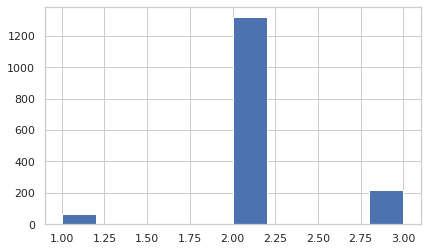

In [10]:
wine.rating.hist()

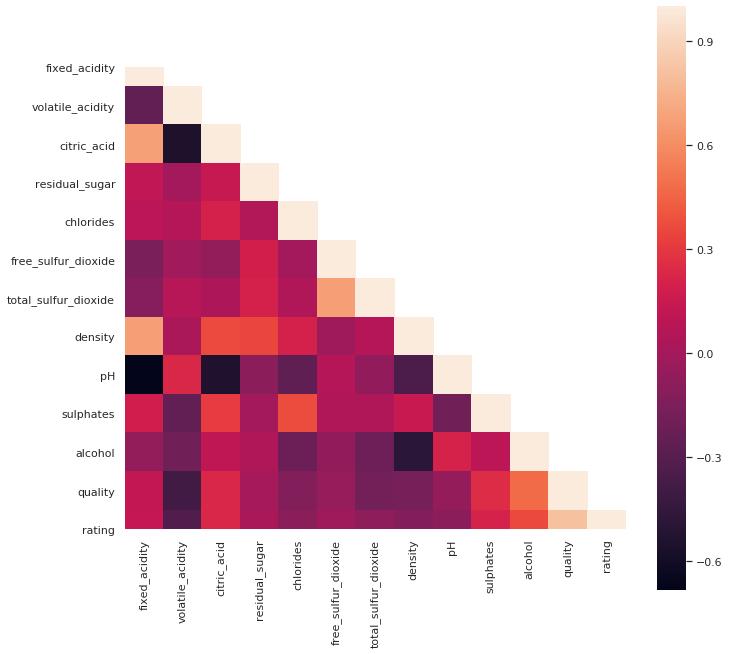

In [289]:
cor_mat = wine.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(10,10)
sns.heatmap(data=cor_mat, mask=mask,
            square=True, cbar=True)

Из графика видно, что pH кореллирует с fixed acidity и citric acid.                                                                       
Нет явной зависимости quality от какой-то одной характеристики.                                                                                   
Quality хорошо коррелирует с alcohol, sulphates, volatile acidity, citric acid.




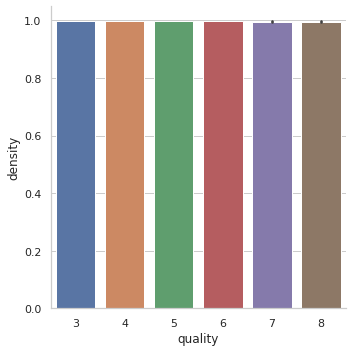

In [11]:

sns.catplot(x='quality', y='density', kind="bar", data=wine)


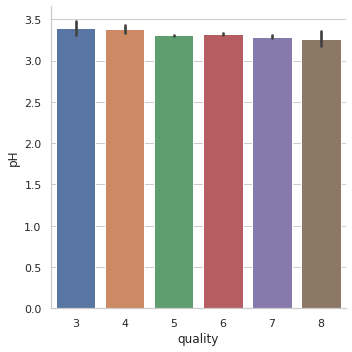

In [12]:
sns.catplot(x='quality', y='pH', kind="bar", data=wine)

Значения density и pH почти не изменяются.
Отбросим их.

# Выбор данных для построения моделей 

In [34]:
X = wine.drop(['quality', 'rating', 'density','pH'], axis=1)
X = preprocessing.scale(X)
Y = wine['rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# DecisionTreeClassifier

In [42]:
model_tree = tree.DecisionTreeClassifier(criterion='entropy')
# подбор параметров дерева 
parametrs = {
             'max_depth': [i for i in range(1,20)],
             'min_samples_leaf': [i for i in range(2,80,5)],
             'min_samples_split': [i for i in range(2,50,5)]
            }
grid_search_cv = GridSearchCV(model_tree, parametrs, cv=5)
grid_search_cv.fit(X_train,Y_train)
grid_search_cv.best_params_

{'max_depth': 2, 'min_samples_leaf': 52, 'min_samples_split': 2}

In [43]:
model_tree = tree.DecisionTreeClassifier(max_depth=2,
                                         min_samples_leaf=52,
                                         min_samples_split=2,
                                         criterion='entropy')
model_tree.fit(X_train, Y_train)
model_tree_cross_val_score = cross_val_score(model_tree, X_test,Y_test,cv=5)
print(f'на обучающей выборке:{model_tree.score(X_train, Y_train)}',
      f'на тестовой выборке:{model_tree.score(X_test,Y_test)}',  
      f'средняя по кросвалидации: {cross_val_score(model_tree, X_test, Y_test,cv=5).mean()}',
      sep='\n')

на обучающей выборке:0.8540145985401459
на тестовой выборке:0.821875
средняя по кросвалидации: 0.8234582913691021


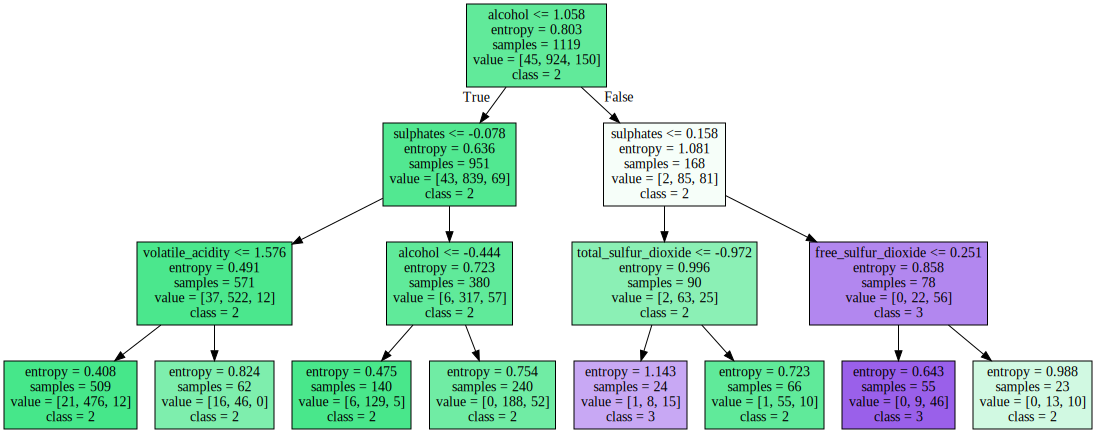

In [23]:
# Визуализация дерева 
X = wine.drop(['quality', 'rating','density','pH'], axis=1)
graph = Source(tree.export_graphviz(model_tree, out_file=None
                                    ,feature_names=list(X)
                                    ,class_names=['1','2','3']
                                    ,filled=True))

display(SVG(graph.pipe(format='svg')))

# Gaussian Naive Bayes

In [52]:
model_gaus = GaussianNB(var_smoothing=1e-09)
model_gaus.fit(X_train, Y_train)
model_gaus_cross_val_score = cross_val_score(model_gaus, X_test,Y_test,cv=5)
print(f'на обучающей выборке:{model_gaus.score(X_train, Y_train)}',
      f'на тестовой выборке:{model_gaus.score(X_test,Y_test)}',  
      f'средняя по кросвалидации: {cross_val_score(model_gaus,X_test,Y_test,cv=5).mean()}',sep='\n') 

на обучающей выборке:0.7924921793534933
на тестовой выборке:0.784375
средняя по кросвалидации: 0.7328067776048343


# Random Forest

In [40]:
model_forest = RandomForestClassifier(max_depth=3, n_estimators=100)
parametrs = {
             'min_samples_leaf': [i for i in range(2,80,4)],
             'min_samples_split': [i for i in range(2,50,5)]
            }
grid_search_cv = GridSearchCV(model_forest, parametrs, cv=5)
grid_search_cv.fit(X_train,Y_train)
grid_search_cv.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 17}

In [41]:
model_forest = RandomForestClassifier(max_depth=3,
                                      min_samples_leaf=2,
                                      min_samples_split=17,
                                      n_estimators=100)
model_forest .fit(X_train, Y_train)
model_forest_cross_val_score = cross_val_score(model_forest, X_test,Y_test,cv=5)
print(f'на обучающей выборке:{model_forest.score(X_train, Y_train)}',
      f'на тестовой выборке:{model_forest.score(X_test,Y_test)}',  
      f'средняя по кросвалидации: {cross_val_score(model_forest, X_test,Y_test,cv=5).mean()}',sep='\n') 


на обучающей выборке:0.862356621480709
на тестовой выборке:0.8328125
средняя по кросвалидации: 0.8219073315326864


# C-Support Vector Classification


In [37]:
model_svc = SVC(gamma=0.22)
parametrs = {
             'kernel':['rbf'],
             'C':[i for i in range(1, 20, 2)],
             'coef0':[0.0005, 0.001, 0.005, 0.01, 0.015, 0.1, 0.5] 
            }
grid_search_cv = GridSearchCV(model_svc, parametrs, cv=5)
grid_search_cv.fit(X_train,Y_train)
grid_search_cv.best_params_


{'C': 1, 'coef0': 0.0005, 'kernel': 'rbf'}

In [38]:
model_svc = SVC(gamma=0.22, C=1, coef0=0.0005, kernel='rbf')
model_svc.fit(X_train, Y_train)
model_svc_cross_val_score = cross_val_score(model_svc, X_test,Y_test,cv=5)
print(f'на обучающей выборке:{model_svc.score(X_train, Y_train)}',
      f'на тестовой выборке:{model_svc.score(X_test,Y_test)}',  
      f'средняя по кросвалидации: {cross_val_score(model_svc, X_test,Y_test,cv=5).mean()}',
      sep='\n') 


на обучающей выборке:0.8790406673618353
на тестовой выборке:0.8359375
средняя по кросвалидации: 0.8375329037722029


# Сравнение моделей 

In [32]:
data_score = pd.DataFrame({'DecisionTreeClassifier': model_tree_cross_val_score,
                           'GaussianNB': model_gaus_cross_val_score,
                           'RandomForestClassifier': model_forest_cross_val_score,
                           'C-Support Vector Classification': model_svc_cross_val_score 
                          })

DecisionTreeClassifier             0.806299
GaussianNB                         0.706225
RandomForestClassifier             0.823010
C-Support Vector Classification    0.818691
dtype: float64

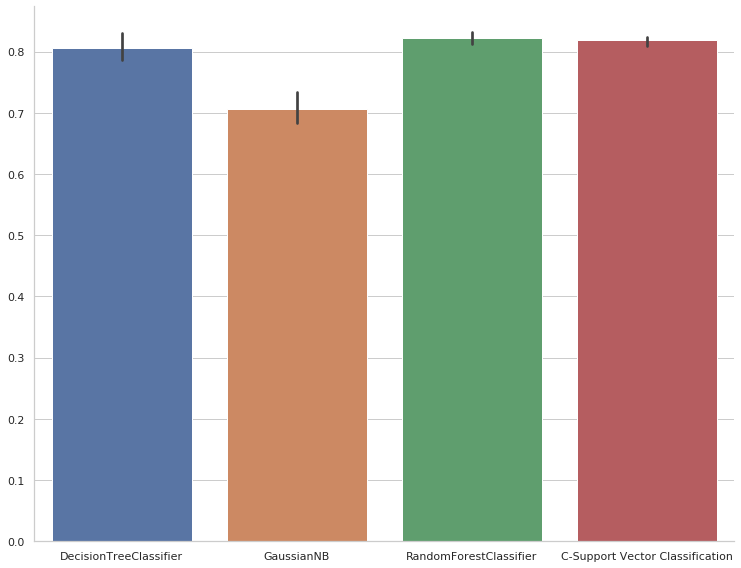

In [33]:
sns.catplot(kind="bar", data = data_score,height=8,aspect=1.3)
data_score.mean()


# Сonclusion

В данных очень мало экземпляров которым, поставили 3, 4 балла, поэтому приведенные алгоритмы имеют низкую предсказательную силу. Скорее всего, на оценку качества вина сильнее влияет социальная составляющая.